In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.exposure import histogram
from pathlib import Path
from urlpath import URL
import json
import glob 
import numpy as np
import seaborn as sns
from skimage.measure import shannon_entropy
import string
import nltk
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from ipywidgets import IntProgress


import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# https://pypi.org/project/pytesseract/
# sudo apt install tesseract-ocr
import pytesseract
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

from prepareCSV import cleanOcrText
pd.options.display.max_columns = None

region = 'US'

[nltk_data] Downloading package words to /home/lilatee/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lilatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lilatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/lilatee/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /home/lilatee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_

In [2]:
df = pd.read_csv(f"./{region}_new_columns.csv")
df = df.loc[:, ["video_id", "thumbnail_link", 'region']]
print(df.shape)
df[:3]

(6283, 3)


,video_id,thumbnail_link,region
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US


### Pobieranie thumbnaili

In [ ]:
def readJSONList(path):
    with open(path, 'r') as file:
        loaded_list = json.loads(file.read())
    return loaded_list

def writeJSONList(path, list_to_save):
    with open(path, 'w') as file:
        file.write(json.dumps(list_to_save))

def downloadThumbnails(df, quality='hq'):
    list_of_ids_without_thumbnail = []
    ids = df["video_id"].values
    urls = df["thumbnail_link"].values
    
    region = df['region'][0]
    Path("./data/thumbnailsHQ/" + region).mkdir(parents=True, exist_ok=True)
    savepath = Path("./data/thumbnailsHQ/" + region)
    filename = quality + 'default.jpg'
    
    for id, url in zip(ids, urls): 
        temp_url = URL(url)
        temp_url = temp_url.parent / filename
        
        try:
            img = io.imread(str(temp_url))
        except Exception:
            list_of_ids_without_thumbnail.append(id)
            print(f"{id} no thumbnail")
            continue
        io.imsave(savepath / (id + ".png") , img)
    
    writeJSONList(savepath / "ids_without_thumbnail.txt", list_of_ids_without_thumbnail)
        
    return list_of_ids_without_thumbnail

In [ ]:
# list_of_ids_without_thumbnail = downloadThumbnails(df)
# df.loc[df.video_id=="0Yp9WS6cJFA",:]

### Średnia wartość kanałów w obrazie, odchylenie, histogramy, entropia, ocr tesseract

In [ ]:
%%time
# Odkomentować zapis jeśli trzeba!!!
imgs_path = Path(f'./data/thumbnailsHQ/{region}')

for i, img_path in enumerate(glob.glob(f"{imgs_path}/*.png")): 
    path = Path(img_path)
    img = io.imread(path)
    
    list_of_pixels = img.reshape(img.shape[0]*img.shape[1], 3)
    mean_of_channels = np.mean(list_of_pixels, axis=0)
    std_of_channels = np.std(list_of_pixels, axis=0)

    df.loc[df.video_id == path.stem, "mean_r"] = mean_of_channels[0]
    df.loc[df.video_id == path.stem, "mean_g"] = mean_of_channels[1]
    df.loc[df.video_id == path.stem, "mean_b"] = mean_of_channels[2]
    
    df.loc[df.video_id == path.stem, "std_r"] = std_of_channels[0]
    df.loc[df.video_id == path.stem, "std_g"] = std_of_channels[1]
    df.loc[df.video_id == path.stem, "std_b"] = std_of_channels[2]
    
    df.loc[df.video_id == path.stem, "entropy"] = shannon_entropy(img)
    df.loc[df.video_id == path.stem, "thumb_ocr_text"] = pytesseract.image_to_string(img)
    
    if (i % 100 == 0):
        print(i, end='\r')

df["clean_thumb_ocr_text"] = df.apply(lambda row: cleanOcrText(row.thumb_ocr_text), axis=1)

df.loc[:, "thumb_ocr_text"] = df.loc[:, "thumb_ocr_text"].fillna('')
df.loc[:, "clean_thumb_ocr_text"] = df.loc[:, "clean_thumb_ocr_text"].fillna('')

df.to_csv(f"./our_data/Etap2/{region}-01_tesseract.csv", index=False)
df[:3]

### CHECKPOINT

In [26]:
df = pd.read_csv(f"./our_data/Etap2/{region}-01_tesseract.csv")
df[:5]

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US,83.791198,77.128183,74.980914,78.653796,73.570512,73.087883,"[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...",6.818234,\n,NaN
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US,53.131123,50.240133,55.462459,66.342402,62.884021,62.213755,"[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...",6.185228,\n,NaN
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,puqaWrEC7tY,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,US,85.942714,86.987807,84.269149,85.556903,83.919807,85.287368,"[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...",6.434697,\n,NaN
4,d380meD0W0M,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,US,111.840347,103.171238,102.399716,104.868991,96.903546,93.691704,"[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...",6.510005,\n,NaN


In [ ]:
# ocr_videos = df.loc[df.clean_thumb_ocr_text != '',:][["video_id","thumb_ocr_text","clean_thumb_ocr_text"]]
# ocr_videos.shape

### Wizualizacja OCRa tesseract

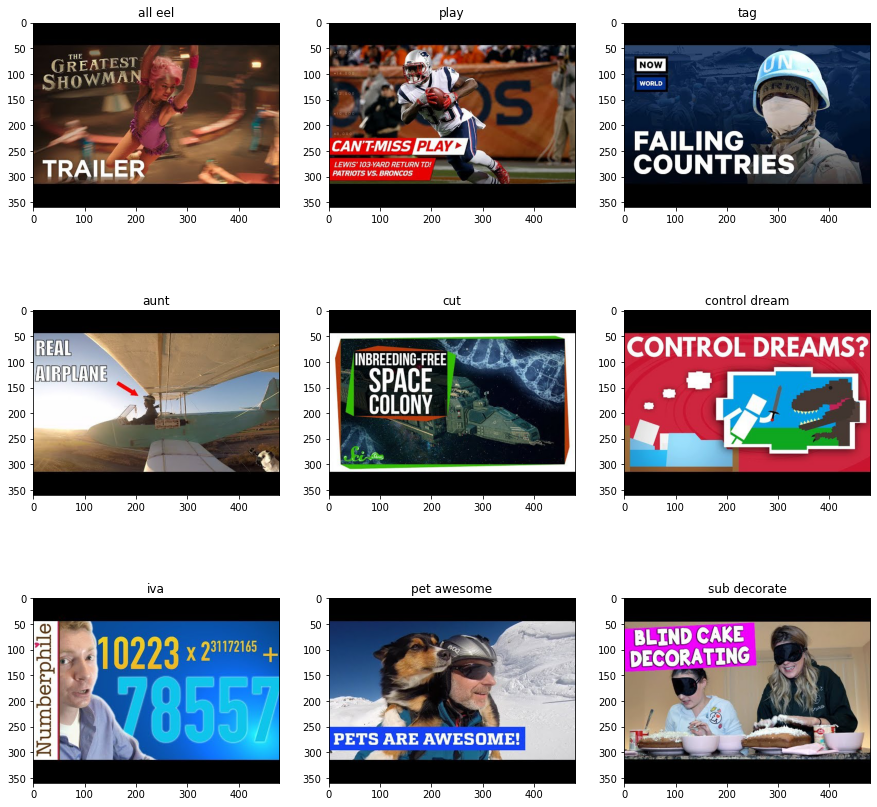

In [4]:
df = pd.read_csv(f"./our_data/Etap2/{region}-01_tesseract.csv")

df.loc[:, "thumb_ocr_text"] = df.loc[:, "thumb_ocr_text"].fillna('')
df.loc[:, "clean_thumb_ocr_text"] = df.loc[:, "clean_thumb_ocr_text"].fillna('')

# ocr_videos = df.loc[df.clean_thumb_ocr_text != '',:][["video_id","thumb_ocr_text","clean_thumb_ocr_text"]][:10]
# test_ocr_videos_ids = ocr_videos.video_id.values
test_ocr_videos_ids = ['jr9QtXwC9vc', '9wRQljFNDW8', 'GgVmn66oK_A', 'eNSN6qet1kE',
       'B5HORANmzHw', 'vU14JY3x81A', 'fcVjitaM3LY', 'ogYum4kWXgk',
       'KODzih-pYlU', '1cgK-BIrXes']

n_of_cols = 3
n_of_rows = int(ocr_videos.shape[0]/n_of_cols)
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*5, n_of_rows*5))

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        video = ocr_videos[i*n_of_cols+j:i*n_of_cols+j+1]
        video_id = video.video_id.values[0]
        path = Path(f'./data/thumbnailsHQ/{region}/{video_id}.png')
        
        ax.set_title(video.clean_thumb_ocr_text.values[0])
        img = io.imread(str(path))
        ax.imshow(img)

In [ ]:
# ll = df.loc[df.clean_thumb_ocr_text != '',:][["thumb_ocr_text","clean_thumb_ocr_text"]].values
# print(ll.shape)
# print(df.shape)
# for el in ll:
#     print("="*100)
#     print(el[1])
#     print("="*100)
#     print(el[0])


### Lepszy OCR

#### [Wykrywanie napisów - https://github.com/clovaai/deep-text-recognition-benchmark](https://github.com/clovaai/deep-text-recognition-benchmark)

In [ ]:
%run CRAFT-pytorch/test_modified.py \
    --trained_model="CRAFT-pytorch/craft_mlt_25k.pth" \
    --test_folder="data/thumbnailsHQ/{region}"\
    --cuda=True \
    --result_folder="data/OCR_result/{region}/"

#### Wycięcie fragmentów obrazów z napisami

In [ ]:
from skimage import io
import numpy as np
from pathlib import Path
import glob
import json

def genSlicesWithText(CRAFT_path_results=f"./data/OCR_result/{region}/", path_images=f"./data/thumbnailsHQ/{region}", out_df_path=f"our_data/Etap2/{region}-02_ocr.csv"):
    def bounding_box(points):
        x_coordinates, y_coordinates = zip(*points)
        return [(int(min(x_coordinates)), int(min(y_coordinates))), (int(max(x_coordinates)), int(max(y_coordinates)))]

    CRAFT_path_results = Path(CRAFT_path_results)
    path_images = Path(path_images)
    
    result_df = pd.DataFrame(columns=['video_id', 'word_id' ,'ocr_text', 'bbox'])
    for j, result_path in enumerate(glob.glob(str(CRAFT_path_results) + "/*.txt")):
        result_path = Path(result_path)
        video_id = result_path.stem[4:] # removing "res_" to obtain video_id
        
        img_path = Path(path_images / (video_id + ".png"))
        img = io.imread(img_path)
        shape = img.shape

        bboxes_path = CRAFT_path_results / ('res_' + img_path.stem + ".txt")
        bboxes = []
        with open(bboxes_path, "r") as bboxFile:
            for line in bboxFile.readlines():
                numbers = np.array(line.split(',')).astype(int)
                points = []

                for x,y in zip(numbers[::2], numbers[1::2]):
                    points.append((x, y))
                bboxes.append(bounding_box(points))


        if len(bboxes) > 0:
                Path(CRAFT_path_results / "words" / img_path.stem).mkdir(parents=True, exist_ok=True)
                img_dir = Path(CRAFT_path_results / "words" / img_path.stem)

        for i, bbox in enumerate(bboxes):
            img_slice = img[max(bbox[0][1], 0): min(bbox[1][1], shape[0]), max(bbox[0][0], 0):min(bbox[1][0], shape[1])]
            result_df = result_df.append({
                'video_id': video_id , 
                'word_id': i , 
                'ocr_text': '', 
                'bbox': json.dumps(bbox)}, ignore_index=True
            )
            
            io.imsave(img_dir / f"{i}.png", img_slice)
            
        if j % 100 == 0:
            print(j, end='\r')
            
    result_df.to_csv(out_df_path, index=False)

out_df_path = f"our_data/Etap2/{region}-02_ocr.csv"
genSlicesWithText(CRAFT_path_results=f"./data/OCR_result/{region}/", path_images=f"./data/thumbnailsHQ/{region}", out_df_path=out_df_path )

#### [Rozpoznawanie napisów - https://github.com/clovaai/CRAFT-pytorch](https://github.com/clovaai/CRAFT-pytorch)

In [ ]:
%run deep-text-recognition-benchmark/demo_modified.py \
--Transformation TPS \
--FeatureExtraction ResNet \
--SequenceModeling BiLSTM \
--Prediction Attn \
--image_folder "data/OCR_result/{region}/words/" \
--saved_model "deep-text-recognition-benchmark/TPS-ResNet-BiLSTM-Attn.pth" \
--out_df_path "{out_df_path}"

### Łączenie wykrytych napisów w jeden, aby zapisać w kolumnie. Przed tym czyszczenie tzn.:
- usuwanie stopwords, 
- usuwanie słów krótszych niż 3, 
- lematyzacja,
- sprawdzenie czy słowo istnieje w słowniku.

### CHECKPOINT

In [27]:
df_ocr = pd.read_csv(f"./our_data/Etap2/{region}-02_ocr.csv")
df_ocr[:5]

,video_id,word_id,ocr_text,bbox
0,-1Hm41N0dUs,0,see,"[[192, 144], [221, 162]]"
1,-1Hm41N0dUs,1,14,"[[220, 148], [242, 165]]"
2,-1Hm41N0dUs,2,win,"[[249, 149], [291, 168]]"
3,-1Hm41N0dUs,3,jimmy,"[[41, 206], [105, 230]]"
4,-1Hm41N0dUs,4,scommel,"[[11, 207], [179, 304]]"


In [29]:
from prepareCSV import concatAndCleanOcrTextV2
df_ocr = df_ocr.groupby(by="video_id", axis=0).apply(lambda x: concatAndCleanOcrTextV2(x)).reset_index()
df_ocr.to_csv(f"our_data/Etap2/{region}-03_ocr_groupby.csv", index=False)
df_ocr[:10]

,video_id,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes
0,-1Hm41N0dUs,see 14 win jimmy scommel livei,see win jimmy scommel livei,"[""[[192, 144], [221, 162]]"", ""[[249, 149], [29..."
1,-1yT-K3c6YI,truth or dare,truth dare,"[""[[156, 186], [285, 225]]"", ""[[166, 266], [28..."
2,-2RVw2_QyxQ,chawdows chess club cosco andischolatic conter,chawdows chess club cosco andischolatic conter,"[""[[249, 221], [438, 280]]"", ""[[115, 221], [15..."
3,-2aVkGcI7ZA,1,,[]
4,-2b4qSoMnKE,cnn,cnn,"[""[[13, 224], [180, 303]]""]"
5,-2wRFv-mScQ,10 top moments celebrity game,top moment celebrity game,"[""[[24, 124], [113, 196]]"", ""[[232, 209], [362..."
6,-35jibKqbEo,skies casties glitter under spanish,sky casties glitter spanish,"[""[[356, 158], [384, 168]]"", ""[[206, 160], [24..."
7,-37nIo_tLnk,wallace rasheed decemb ren,wallace rasheed decemb ren,"[""[[182, 260], [242, 274]]"", ""[[124, 261], [18..."
8,-39ysKKpE7I,first take,first take,"[""[[20, 232], [140, 261]]"", ""[[21, 258], [136,..."
9,-3h4Xt9No9o,sea ofokhotsk okhotak thaw 6 uncist part3 land...,sea ofokhotsk okhotak thaw uncist part3 lando ...,"[""[[13, 208], [33, 217]]"", ""[[21, 48], [76, 58..."


### Dodanie kolumny z wynikami nowego OCRa

In [30]:
df_ocr = df_ocr.set_index("video_id")
df = df.set_index("video_id").join(df_ocr).reset_index()
df["bboxes"] = df["bboxes"].fillna(json.dumps([]))
df.to_csv(f"our_data/Etap2/{region}-04_ocrV2.csv", index=False)
df[:5]

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US,83.791198,77.128183,74.980914,78.653796,73.570512,73.087883,"[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...",6.818234,\n,NaN,NaN,NaN,[]
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US,53.131123,50.240133,55.462459,66.342402,62.884021,62.213755,"[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...",6.185228,\n,NaN,the trump presidency,trump presidency,"[""[[68, 169], [105, 178]]"", ""[[108, 169], [176..."
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,puqaWrEC7tY,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,US,85.942714,86.987807,84.269149,85.556903,83.919807,85.287368,"[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...",6.434697,\n,NaN,this at look photograph gmm youlube originals,look photograph gmm youlube original,"[""[[262, 169], [334, 216]]"", ""[[269, 190], [41..."
4,d380meD0W0M,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,US,111.840347,103.171238,102.399716,104.868991,96.903546,93.691704,"[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...",6.510005,\n,NaN,going baldzi dare youi,baldzi dare youi,"[""[[57, 122], [193, 200]]"", ""[[0, 262], [94, 2..."


### Wizualizacja OCRa V2

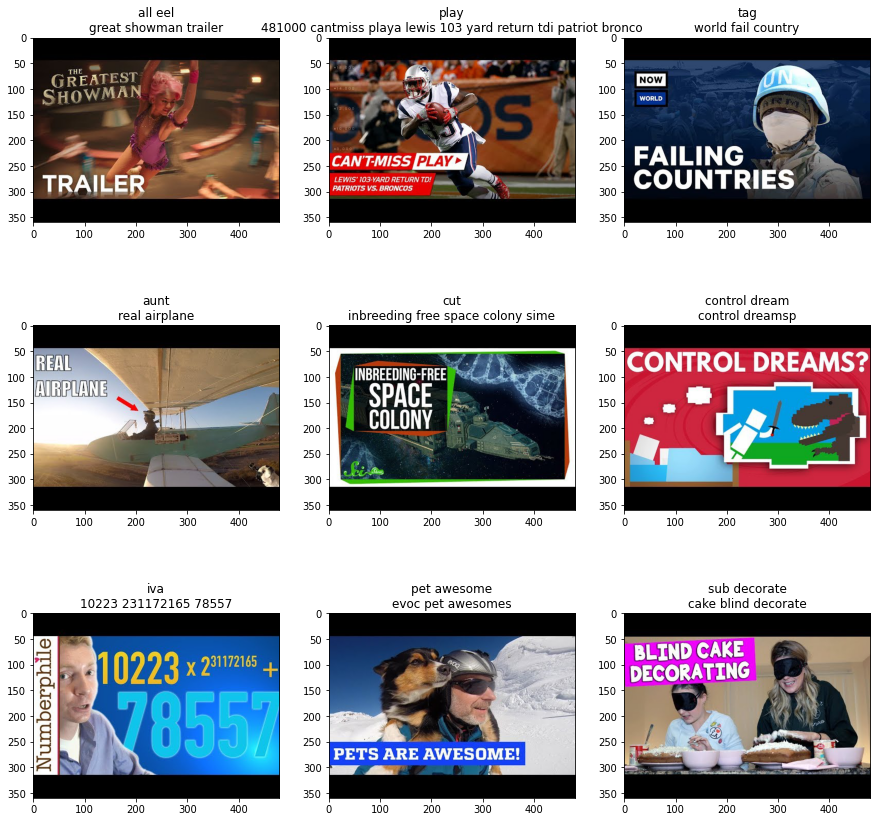

In [5]:
df = pd.read_csv(f"./our_data/Etap2/{region}-04_ocrV2.csv")

df.loc[:, "thumb_ocr_text_V2"] = df.loc[:, "thumb_ocr_text_V2"].fillna('')
df.loc[:, "clean_thumb_ocr_text_V2"] = df.loc[:, "clean_thumb_ocr_text_V2"].fillna('')

# ocr_videos = df.loc[df.clean_thumb_ocr_text_V2 != '',:][["video_id","thumb_ocr_text_V2","clean_thumb_ocr_text_V2"]][:10]
test_ocr_videos_ids = ['jr9QtXwC9vc', '9wRQljFNDW8', 'GgVmn66oK_A', 'eNSN6qet1kE',
       'B5HORANmzHw', 'vU14JY3x81A', 'fcVjitaM3LY', 'ogYum4kWXgk',
       'KODzih-pYlU', '1cgK-BIrXes']
ocr_videos = df.loc[df.video_id.isin(test_ocr_videos_ids), :]


n_of_cols = 3
n_of_rows = int(ocr_videos.shape[0]/n_of_cols)
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*5, n_of_rows*5))

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        video = ocr_videos[i*n_of_cols+j:i*n_of_cols+j+1]
        video_id = video.video_id.values[0]
        path = Path(f'./data/thumbnailsHQ/{region}/{video_id}.png')
        
        ax.set_title(f"{video.clean_thumb_ocr_text.values[0]}\n{video.clean_thumb_ocr_text_V2.values[0]}")
        img = io.imread(str(path))
        ax.imshow(img)

### Dodanie kolumny zawierającej średni punkt napisów w obrazie

In [31]:
def avg_texts_coords(bboxes):
    bboxes = json.loads(bboxes)
    if (len(bboxes) == 0):
        return json.dumps([-1, -1])
    middle_corrds_of_texts = []
    for bbox in bboxes:
        p1, p2 = json.loads(bbox)
        p1 = np.array(p1)
        p2 = np.array(p2)
        middle_text_coords = np.mean([p1, p2], axis=0)
        middle_corrds_of_texts.append(middle_text_coords)
#         print(p1, p2)
#         print(middle_text_coords)
    
    return json.dumps(list(np.mean(middle_corrds_of_texts, axis=0)))
    
df["avg_texts_coords"] = df.apply(lambda row: avg_texts_coords(row.bboxes), axis=1) 
df["avg_texts_coordX"] = df.apply(lambda row: json.loads(row.avg_texts_coords)[0],axis=1)
df["avg_texts_coordY"] = df.apply(lambda row: json.loads(row.avg_texts_coords)[1],axis=1)

df.to_csv(f"./our_data/Etap2/{region}-05_middle_texts_point.csv", index=False)
df[:5]

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US,83.791198,77.128183,74.980914,78.653796,73.570512,73.087883,"[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...",6.818234,\n,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US,53.131123,50.240133,55.462459,66.342402,62.884021,62.213755,"[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...",6.185228,\n,NaN,the trump presidency,trump presidency,"[""[[68, 169], [105, 178]]"", ""[[108, 169], [176...","[114.25, 173.5]",114.250000,173.500000
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000
3,puqaWrEC7tY,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,US,85.942714,86.987807,84.269149,85.556903,83.919807,85.287368,"[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...",6.434697,\n,NaN,this at look photograph gmm youlube originals,look photograph gmm youlube original,"[""[[262, 169], [334, 216]]"", ""[[269, 190], [41...","[217.9, 256.2]",217.900000,256.200000
4,d380meD0W0M,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,US,111.840347,103.171238,102.399716,104.868991,96.903546,93.691704,"[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...",6.510005,\n,NaN,going baldzi dare youi,baldzi dare youi,"[""[[57, 122], [193, 200]]"", ""[[0, 262], [94, 2...","[74.33333333333333, 248.16666666666666]",74.333333,248.166667


### CHECKPOINT

In [3]:
df = pd.read_csv(f"./our_data/Etap2/{region}-05_middle_texts_point.csv")
df[:5]

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound
0,Jw1Y-zhQURU,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000,0.0
1,3s1rvMFUweQ,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000,0.0
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.502830,71.743704,79.699635,83.992492,83.883918,83.748135,6.470819,\n,NaN,wigy water an vevo,water,"[""[[282, 116], [468, 204]]""]","[375.0, 160.0]",375.000000,160.000000,0.0
3,PUTEiSjKwJU,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,GB,86.534334,73.284271,69.150666,78.330501,71.675730,68.933206,6.839139,\n\ney tderr ott\n\nSTE a CLASS OF 92\n...,class,3 10 3 92 salford city class of 92 4 dudley2n ...,city class burton,"[""[[174, 262], [197, 277]]"", ""[[280, 262], [31...","[231.83333333333334, 279.1666666666667]",231.833333,279.166667,0.0
4,rHwDegptbI4,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000,0.0


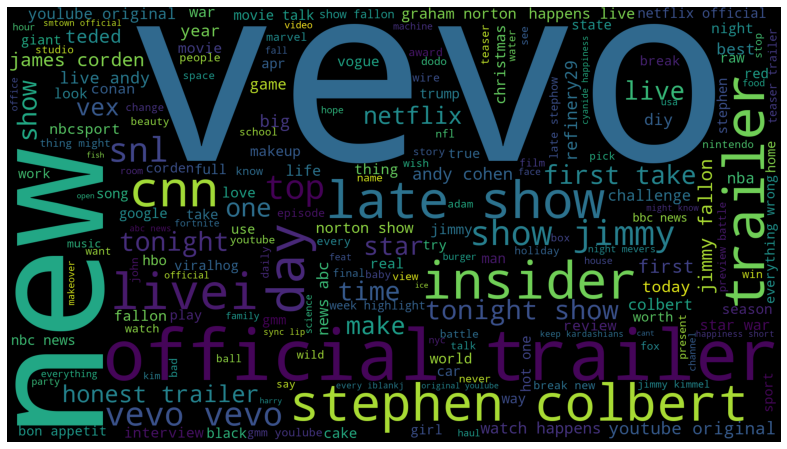

In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.pyplot import figure

df = pd.read_csv(f"./our_data/Etap2/{region}-05_middle_texts_point.csv")

df.loc[:, "clean_thumb_ocr_text_V2"] = df.loc[:, "clean_thumb_ocr_text_V2"].fillna('')
all_words = ' '.join(df.loc[:, "clean_thumb_ocr_text_V2"].values)

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1920, height=1080).generate(all_words)

figure(figsize=(16, 8))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Analiza sentymentu

In [33]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

df = pd.read_csv(f"./our_data/Etap2/{region}-05_middle_texts_point.csv")

sia = SentimentIntensityAnalyzer()

df["clean_thumb_ocr_text_V2"] = df["clean_thumb_ocr_text_V2"].fillna('')
df["ocr_sentiment_compound"] = df.apply(lambda row: sia.polarity_scores(row.clean_thumb_ocr_text_V2)['compound'] ,axis=1)
df.to_csv(f"./our_data/Etap2/{region}-06_sentiment.csv", index=False)
df[:10]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US,83.791198,77.128183,74.980914,78.653796,73.570512,73.087883,"[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...",6.818234,\n,NaN,NaN,,[],"[-1, -1]",-1.000000,-1.000000,0.0000
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US,53.131123,50.240133,55.462459,66.342402,62.884021,62.213755,"[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...",6.185228,\n,NaN,the trump presidency,trump presidency,"[""[[68, 169], [105, 178]]"", ""[[108, 169], [176...","[114.25, 173.5]",114.250000,173.500000,0.0000
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],"[-1, -1]",-1.000000,-1.000000,0.0000
3,puqaWrEC7tY,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,US,85.942714,86.987807,84.269149,85.556903,83.919807,85.287368,"[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...",6.434697,\n,NaN,this at look photograph gmm youlube originals,look photograph gmm youlube original,"[""[[262, 169], [334, 216]]"", ""[[269, 190], [41...","[217.9, 256.2]",217.900000,256.200000,0.3182
4,d380meD0W0M,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,US,111.840347,103.171238,102.399716,104.868991,96.903546,93.691704,"[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...",6.510005,\n,NaN,going baldzi dare youi,baldzi dare youi,"[""[[57, 122], [193, 200]]"", ""[[0, 262], [94, 2...","[74.33333333333333, 248.16666666666666]",74.333333,248.166667,0.0000
5,gHZ1Qz0KiKM,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,US,150.602332,134.756968,133.509641,90.790983,89.014356,92.819741,"[39205, 1923, 632, 290, 295, 206, 112, 98, 126...","[39205, 1923, 632, 290, 295, 206, 112, 98, 126...","[39205, 1923, 632, 290, 295, 206, 112, 98, 126...",5.878455,\n,NaN,NaN,,[],"[-1, -1]",-1.000000,-1.000000,0.0000
6,39idVpFF7NQ,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,US,80.836811,76.387865,71.447940,88.515344,85.925652,83.068483,"[39093, 2108, 1429, 892, 912, 781, 804, 807, 8...","[39093, 2108, 1429, 892, 912, 781, 804, 807, 8...","[39093, 2108, 1429, 892, 912, 781, 804, 807, 8...",6.645159,\n,NaN,snl,snl,"[""[[10, 224], [108, 304]]""]","[59.0, 264.0]",59.000000,264.000000,0.0000
7,nc99ccSXST0,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,US,122.328322,118.158756,113.395197,90.417442,88.785801,89.142896,"[42848, 2338, 1451, 801, 654, 516, 516, 423, 4...","[42848, 2338, 1451, 801, 654, 516, 516, 423, 4...","[42848, 2338, 1451, 801, 654, 516, 516, 423, 4...",6.343036,\n,NaN,ice cream 5 gadgets,ice cream gadget,"[""[[337, 61], [380, 86]]"", ""[[384, 61], [476, ...","[401.8333333333333, 87.5]",401.833333,87.500000,0.0000
8,jr9QtXwC9vc,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,US,78.744936,52.365660,39.594028,67.015371,51.078793,43.429655,"[37612, 2229, 898, 357, 451, 352, 232, 184, 20...","[37612, 2229, 898, 357, 451, 352, 232, 184, 20...","[37612, 2229, 898, 357, 451, 352, 232, 184, 20...",6.492153,ue\nBab - ‘all 4\n\nye “Ss\nEel — 4 <=\n,all eel,the greatest showman trailer,great showman trailer,"[""[[33, 64], [206, 100]]"", ""[[16, 91], [214, 1...","[117.33333333333333, 160.0]",117.333333,160.000000,0.6249
9,TUmyygCMMGA,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,US,129.344497,153.661134,149.032014,87.251804,96.298431,104.043511,"[37987, 2019, 2102, 487, 151, 272, 56, 31, 40,...","[379

### Wizualizacja statystyk liczbowych

IndexError: list index out of range

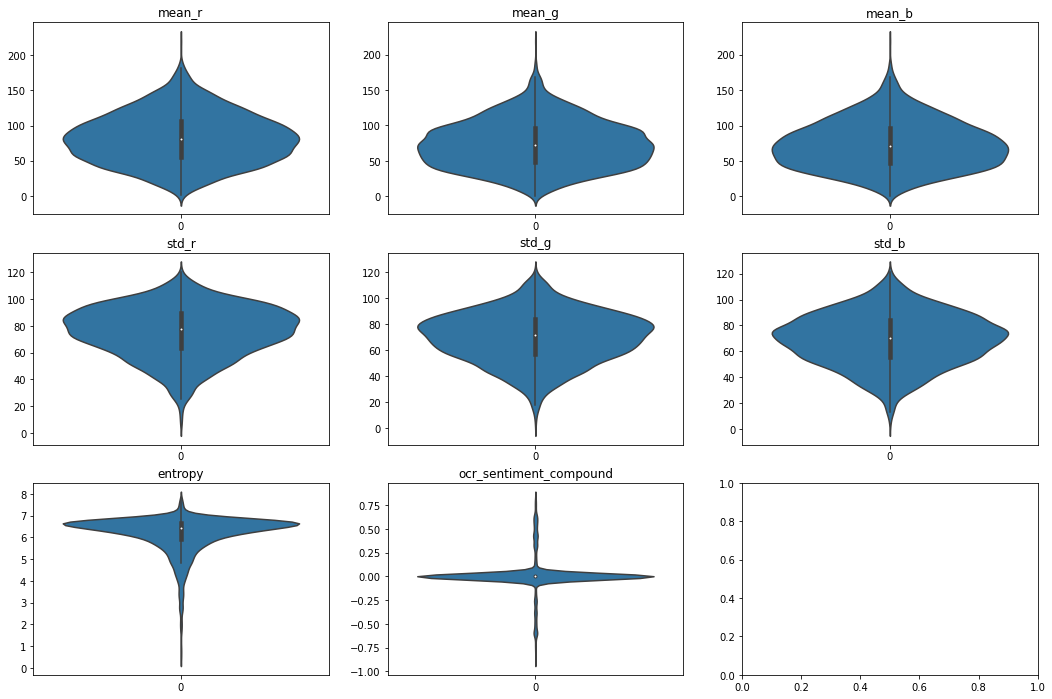

In [13]:
import math
df = pd.read_csv(f"./our_data/Etap2/{region}-06_sentiment.csv")

list_of_columns = [
    'mean_r', 'mean_g', 'mean_b',
    'std_r', 'std_g', 'std_b', 
    'entropy', 
    'ocr_sentiment_compound'
]
n_of_cols = 3
n_of_rows = int(math.ceil(len(list_of_columns)/n_of_cols))
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*6, n_of_rows*4))

data = df.loc[:, list_of_columns]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_title(list_of_columns[i*n_of_cols+j])
        sns.violinplot(ax=ax,data=df.loc[:, list_of_columns[i*n_of_cols+j]])

### Utworzenie wektora cech z ResNet18

In [51]:
%%time
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# region = 'US'
df = pd.read_csv(f"./our_data/Etap2/{region}-06_sentiment.csv")

# Odkomentować zapis jeśli trzeba!!!
imgs_path = Path(f'./data/thumbnailsHQ/{region}')

# # Load the pretrained model
model = models.resnet18(pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for i, img_path in enumerate(glob.glob(f"{imgs_path}/*.png")): 
    path = Path(img_path)
    imgPIL = Image.open(path)
    
    input_tensor = preprocess(imgPIL)
    input_batch = input_tensor.unsqueeze(0)
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    features_vector = torch.zeros(512)
    def copy_data(module, input_, output):
        features_vector.copy_(output.data.flatten())
        
    h = layer.register_forward_hook(copy_data)
    
    with torch.no_grad():
        output = model(input_batch)

    df.loc[df.video_id == path.stem, "features_vec_resnet18"] = json.dumps(features_vector.tolist())    

    if (i % 100 == 0):
        print(i, end='\r')


df.to_csv(f"./our_data/Etap2/{region}-07_ResNet.csv", index=False)
df[:5]

CPU times: user 16min 59s, sys: 2min 4s, total: 19min 4s
Wall time: 19min 18s


,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,features_vec_resnet18
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US,83.791198,77.128183,74.980914,78.653796,73.570512,73.087883,"[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...","[38336, 2426, 1188, 690, 848, 602, 597, 711, 1...",6.818234,\n,NaN,NaN,NaN,[],"[-1, -1]",-1.00,-1.000000,"[0.028933335095643997, 1.5294386148452759, 0.4..."
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US,53.131123,50.240133,55.462459,66.342402,62.884021,62.213755,"[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...","[48274, 4068, 2082, 1566, 1196, 1059, 1116, 10...",6.185228,\n,NaN,the trump presidency,trump presidency,"[""[[68, 169], [105, 178]]"", ""[[108, 169], [176...","[114.25, 173.5]",114.25,173.500000,"[0.34424084424972534, 2.8481504917144775, 0.59..."
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.00,-1.000000,NaN
3,puqaWrEC7tY,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,US,85.942714,86.987807,84.269149,85.556903,83.919807,85.287368,"[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...","[46590, 3405, 1702, 1125, 946, 831, 860, 821, ...",6.434697,\n,NaN,this at look photograph gmm youlube originals,look photograph original,"[""[[262, 169], [334, 216]]"", ""[[269, 190], [41...","[289.0, 235.66666666666666]",289.00,235.666667,"[0.10734694451093674, 3.141456365585327, 1.885..."
4,d380meD0W0M,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,US,111.840347,103.171238,102.399716,104.868991,96.903546,93.691704,"[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...","[47085, 4968, 3326, 2840, 2207, 1674, 1422, 12...",6.510005,\n,NaN,going baldzi dare youi,dare,"[""[[0, 262], [94, 297]]""]","[47.0, 279.5]",47.00,279.500000,"[0.8179275393486023, 2.0939841270446777, 0.666..."


### PCA

/home/lilatee/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


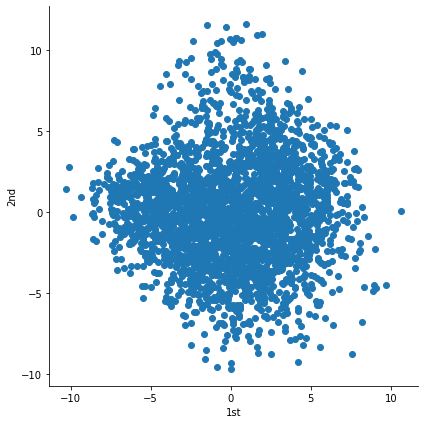

In [76]:
from sklearn import decomposition

df = pd.read_csv(f"./our_data/Etap2/etap2_{region}_ResNet.csv")
list_of_vecs = df.loc[df.features_vec_resnet18.notnull(), "features_vec_resnet18"].values
list_of_vecs = list(map(json.loads, list_of_vecs))

pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(list_of_vecs)
pca_df = pd.DataFrame(pca_data, columns=["1st", "2nd"])
sns.FacetGrid(pca_df, size=6).map(plt.scatter, "1st", "2nd")